# Analysis of Time Based Metrics

## Setup

In [16]:
import os
import sys
from collections import defaultdict

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
os.chdir('/users/dane/src/datatools/ipy/notebooks/pt/dev/')
sys.path.append('/users/dane/src/datatools/analytics/')

import pertest.util
from pertest.util import *

In [7]:
import pylab
pylab.rcParams['figure.figsize'] = (14,10)

# setup lists
m_borderline = [77437, 77445, 81495, 81920, 81813]
m_fail = [72864, 72869, 81478, 81487, 81495, 81381, 81386, 81388, 81390, 81395]
m_shift = [72843, 75978, 76137, 76141, 76341, 76928, 76941, 79328, 72852, 80884]

In [8]:
# data is linked to ~/data
df = pd.read_csv('../data/v14_b60-73.csv')
df['value'] = df['t_value']  # required for level_shift
print(len(df), 'records read')
# keep only time based metric data
tdf = df[df.m_name.apply(lambda x: '$T' in x)]
print(len(tdf), 'time based records')
print(len(tdf.m_id.unique()), 'unique metrics')

1661364 records read
998746 time based records
8999 unique metrics


## Bin Metrics

Metrics behave quite differently when the mean is 50uSec vs 50 sec.  Because of this I will bin the statistics into groups based on their mean.  To determine the right grouping I will look at some statistics of the metrics first.

In [9]:
# build metric dataframe
tdf = tdf.sort_values(by='build')  # make sure it's in the right order
d = []
for m_id, items in tdf.groupby('m_id'):
    rec = items.iloc[0]
    f15 = items[:15]
    l15 = items[-15:]
    f15m = f15.t_value.median()
    m = items.t_value.median()
    # do all points fall within .1 of mean
    avg = items.t_value.mean()
    mx = items.t_value.max()
    mn = items.t_value.min()
    m100 = ((mx-avg)) <= 0.1 and ((avg-mn) <= 0.1)
    
    Q1a = f15.t_value.quantile(0.20)
    Q3a = f15.t_value.quantile(0.80)
    Q1b = l15.t_value.quantile(0.20)
    Q3b = l15.t_value.quantile(0.80)

    minfo = dict(
        m_id=rec.m_id,
        name=rec.m_name,
        test_case=rec.test_case,
        f15median=f15m,
        f15mean=f15.t_value.mean(),
        f15max=f15.t_value.max(),
        f15min=f15.t_value.min(),
        f15q10=f15.t_value.quantile(0.10),
        f15q80=f15.t_value.quantile(0.80),
        f15q90=f15.t_value.quantile(0.90),
        f15range=f15.t_value.max() - f15.t_value.min(),
        l15median=l15.t_value.median(),
        l15mean=l15.t_value.mean(),
        q80=items.t_value.quantile(0.80),
        q90=items.t_value.quantile(0.90),
        std=items.t_value.std(),
        median=m,
        mean=avg,
        max=mx,
        min=mn,
        range=mx - mn,
        level_shift=(Q1a > Q3b) or (Q1b > Q3a),
        m100=m100
    )
    d.append(minfo)
metrics = pd.DataFrame(d)
metrics.head()

,f15max,f15mean,f15median,f15min,f15q10,f15q80,f15q90,f15range,l15mean,l15median,...,max,mean,median,min,name,q80,q90,range,std,test_case
0,6.375000,5.970382,5.953125,5.834045,5.881836,5.984375,6.040625,0.540955,5.901351,5.921875,...,6.375000,5.897102,5.890625,5.773438,DesEnv:Time(s)$T,5.937500,5.957031,0.601562,0.070034,SolderBall_Import@sim_time
1,16.462891,16.380151,16.378906,16.315979,16.323437,16.412500,16.432166,0.146912,16.458105,16.378906,...,21.759766,16.461938,16.367188,16.234375,DesEnv:Time(s)$T,16.410156,16.470703,5.525391,0.560758,AWR_DRC_25x25@drc_time
2,7.328125,6.862838,6.845703,6.613281,6.666821,6.970557,6.984375,0.714844,6.714307,6.734375,...,7.359375,6.737864,6.734375,6.500000,DesEnv:Time(s)$T,6.830994,6.921875,0.859375,0.146538,Many_Aplac_HB@sim_time
3,26.066406,25.760640,25.757812,25.531250,25.551270,25.866833,25.944800,0.535156,25.489730,25.517822,...,28.410156,25.598325,25.533997,25.187500,DesEnv:Time(s)$T,25.753906,25.785156,3.222656,0.344445,MRF6V12500H_Level1_Rev1_APLAC@sim_time
4,7.863281,7.623979,7.631042,7.507812,7.537500,7.646875,7.656250,0.355469,7.530094,7.496094,...,8.468750,7.571523,7.523438,7.453125,DesEnv:Time(s)$T,7.625000,7.644531,1.015625,0.152405,one_Aplac_HB@sim_time


## Level Shifts

There are a large number of metrics that have, due to code changes, had changes in nominal value.  In performing this analysis we expect these metrics to fail.  We determine a level shift when the 20-80 interquartile range of the first 15 points does not overlap the range of the last 15 points.

In [10]:
# how many level shifts are there?
shifts = list(metrics[metrics.level_shift].m_id)
print('there are', len(shifts), 'level shifts')
print('there are', len(metrics[metrics.m100]), 'metrics with <.1 deltas')
ns = metrics[~metrics.level_shift]
len(ns)

there are 1471 level shifts
there are 7157 metrics with <.1 deltas


7528

## Bin Metrics by Mean

There is a lot of range in the metrics and not all metrics produce useful results.  If a metric has a mean value of 9us and it goes to 90 us we won't really care because there is too much measurement error.  The first step is to determine a lower threshold that we care about and identify the metrics below that threshold.

Let's first take a look at the metrics below 100 ms.

### Mean times below 100 ms

In [11]:
max100 = ns[ns['max'] < .1].copy()
print(len(max100))
max100['max_'] = max100['max']
max100['max'].describe()

4947


count    4947.000000
mean        0.005976
std         0.017195
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000045
max         0.099777
Name: max, dtype: float64

So about 60% of the metrics has maximum times below 100 ms.  If we look at the distribution of these maximum values we get

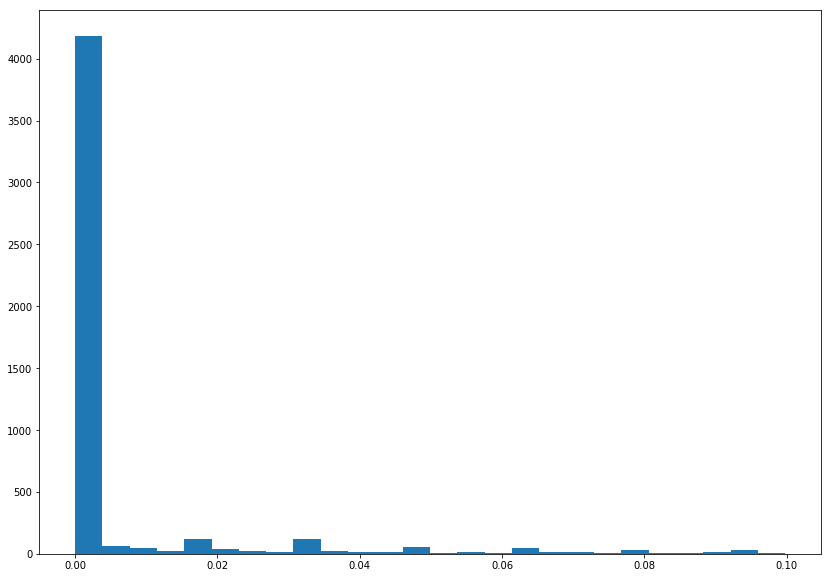

In [12]:
plt.hist(max100['max_'], bins=26)
plt.show()

From this, it seems like a huge number of metrics take so little time, we could actually treat them as VAL_UB and essentially turn them off unless they became significant.  For example we could take all the metrics with means of 10ms or less and make them VAL_UB=20ms.  Let's check how this would work.

In [13]:
ns[(ns['mean'] < .01) & (ns['max'] > .02)]

,f15max,f15mean,f15median,f15min,f15q10,f15q80,f15q90,f15range,l15mean,l15median,...,max,mean,median,min,name,q80,q90,range,std,test_case
27,0.016846,0.009521,0.015625,0.000000,0.000000,0.015625,0.016211,0.016846,0.009342,0.015625,...,0.023438,0.009618,0.015625,0.000000,DesEnv:Time(s)$T,0.015625,0.016113,0.023438,0.008073,TT14605_equations_slow@sim_time
3589,0.010828,0.009266,0.009359,0.008068,0.008314,0.010135,0.010460,0.002761,0.009470,0.009484,...,0.022758,0.009648,0.009464,0.007969,AxPerf:Solve_Total$T,0.010489,0.010632,0.014790,0.001546,tt14195_rotate_port_bug@Axiem
8009,0.016000,0.005200,0.000000,0.000000,0.000000,0.015200,0.016000,0.016000,0.008267,0.015000,...,0.031000,0.006595,0.000000,0.000000,AxMesh:Time(s)$T,0.016000,0.016000,0.031000,0.008014,interior_ports_Axx_external_internal@A1a
8032,0.016000,0.007267,0.000000,0.000000,0.000000,0.016000,0.016000,0.016000,0.008333,0.015000,...,0.032000,0.007919,0.000000,0.000000,AxMesh:Time(s)$T,0.016000,0.016000,0.032000,0.008180,interior_ports_Bxx_above@B1a
8129,0.016000,0.015400,0.015000,0.015000,0.015000,0.016000,0.016000,0.001000,0.008400,0.015000,...,0.031000,0.009414,0.015000,0.000000,AxMesh:Time(s)$T,0.016000,0.016000,0.031000,0.007953,tt15455_em_opt_discrete@EM_Extract_Doc
8159,0.016000,0.011533,0.016000,0.000000,0.000000,0.016000,0.016000,0.016000,0.006267,0.000000,...,0.031000,0.008441,0.015000,0.000000,AxMesh:Time(s)$T,0.016000,0.016000,0.031000,0.008100,Ax_mat_overlap_Axx_both_thin@A1a
8184,0.016000,0.005200,0.000000,0.000000,0.000000,0.015200,0.016000,0.016000,0.006200,0.000000,...,0.031000,0.007874,0.000000,0.000000,AxMesh:Time(s)$T,0.016000,0.016000,0.031000,0.008120,Ax_via_overlap_imped_metal_Cxxx@C1bx
8193,0.016000,0.004200,0.000000,0.000000,0.000000,0.015200,0.016000,0.016000,0.010400,0.015000,...,0.032000,0.008018,0.000000,0.000000,AxMesh:Time(s)$T,0.016000,0.016000,0.032000,0.008675,Ax_via_overlap_thick_metal_B2xx@B2a1
8201,0.016000,0.005267,0.000000,0.000000,0.000000,0.016000,0.016000,0.016000,0.012600,0.016000,...,0.032000,0.009595,0.015000,0.000000,AxMesh:Time(s)$T,0.016000,0.016000,0.032000,0.007971,Ax_via_overlap_thin_metal_A1xx@A1a2
8560,0.020422,0.011073,0.008209,0.007002,0.007169,0.018142,0.019866,0.013420,0.007748,0.007637,...,0.020422,0.008190,0.007642,0.006679,AxAFS:Fit_time(s)$T,0.008449,0.009154,0.013743,0.002308,afs_not_correct@AFS


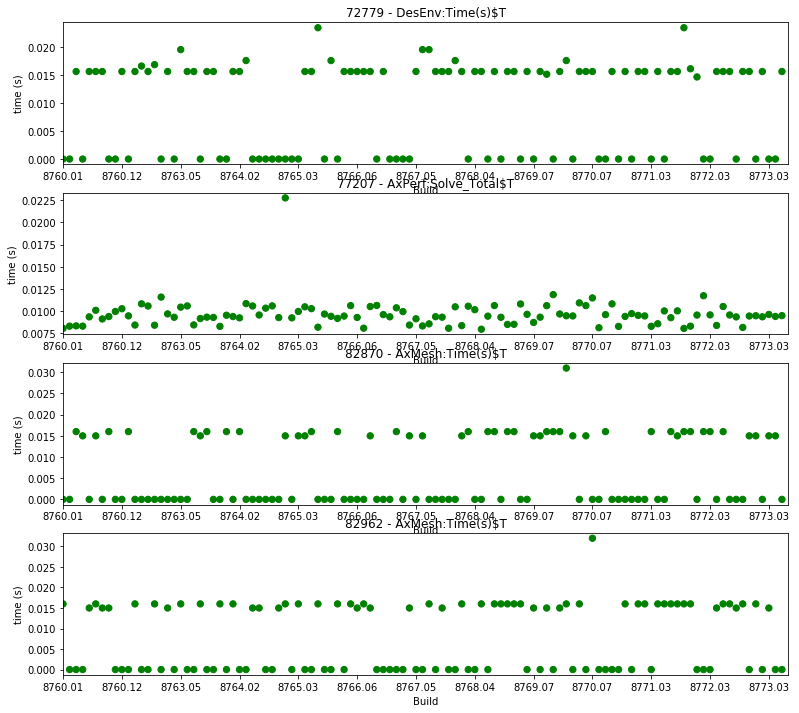

In [17]:
pertest.util.df = df
plotm([72779,77207,82870,82962])

Looking at this, we see that many of these tests are bimodal and this gives us an indication that trying to measure tens of milliseconds is not practical.  The 16ms bands we see here probably also explain why we see this cyclicality in the histogram above.

My conclusion in this is that if there is a 15ms precision to the measurement and you can easily get one 'tick' above or below then you can be 32ms off pretty easily.

There are 4668 metrics with means less than 32ms


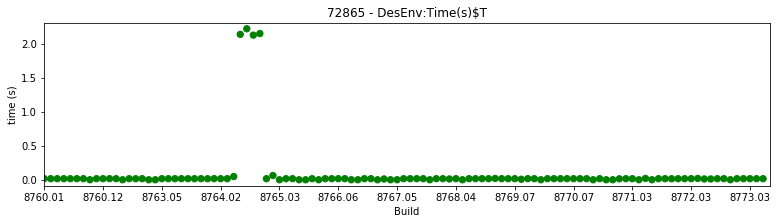

In [18]:
print('There are', len(ns[ns.f15mean < 0.032]), 'metrics with means less than 32ms')
ml = ns[(ns['f15mean'] < .032) & (ns['max'] > .064)]
plotm(list(ml.m_id))

These seem like acceptable exceptions so we **can set all metrics with initial means < 32ms to VAL_UB=64ms**.

For metrics with means between 32ms and 100ms let's set a value of 32ms above the mean as the limit and see how many failures we have.

The number of metrics with means between 32 and 100ms is 330
Of those, 10 have at least 1 points more than 32ms above the mean


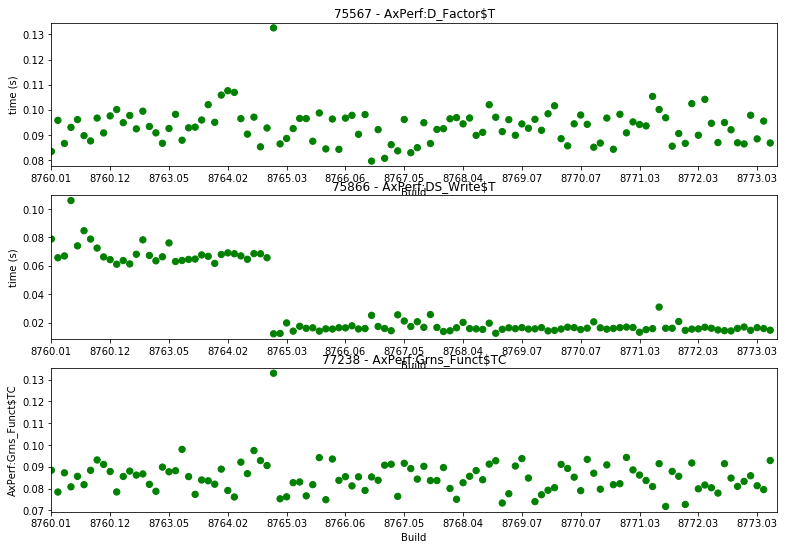

In [19]:
ns_mid = ns[(ns.f15mean > .032) & (ns.f15mean < .1)]
print('The number of metrics with means between 32 and 100ms is', len(ns_mid))
ml=ns_mid[ns_mid['max'] > (ns_mid.f15mean + .032)]
print('Of those,', len(ml), 'have at least 1 points more than 32ms above the mean')
sample = [75567, 75866, 77238]
plotm(sample)

But in looking at a sample of these those points seem like one time exceptions rather than actual failures and could be ignore another way.

This means that for "mid" length metrics we **can use VAL_UB=(mean + 32ms)**.

### Mean Times above 100ms

Next let's turn to metrics having mean times above 100ms.

In [20]:
ns100_1000 = ns[(ns.f15mean > .1) & (ns.f15mean < 1)]
ns1000 = ns[(ns.f15mean > 2) ]
ns100 = ns[(ns.f15mean > .1) ]
print('There are', len(ns100_1000), 'metrics with means between 100ns and 1s')
print('There are', len(ns1000), 'metrics with means above 1s')

There are 1393 metrics with means between 100ns and 1s
There are 709 metrics with means above 1s


(0, 0.8)

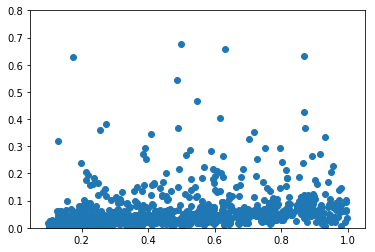

In [21]:
plt.scatter(ns100_1000.f15mean, ns100_1000['max']-ns100_1000.f15mean)
plt.gca().set_ylim([0,.8])

Looking at this data it seems there is a slight dependence in the error on the mean but it is a somewhat weak factor compared to the broader error. Let's look at the 80% quantile value (to leave out the upper outliers) instead.

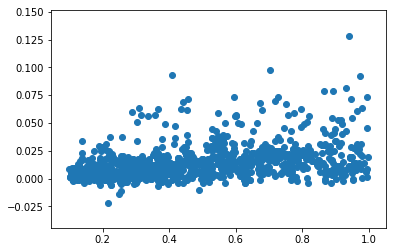

In [22]:
plt.scatter(ns100_1000.f15mean, ns100_1000['q90']-ns100_1000.f15mean)
#plt.gca().set_ylim([0,.1])

This gives us a much more clear perspective of the underlying repeatability error. In looking at this data, it seems that while the error does scale with mean, the big issue we have is at the lower means due to the larger volume of tests there.  Using a 64ms tolerance over the entire range might make sense.

In [23]:
t64 = ns100_1000[ns100_1000['q90'] > (ns100_1000.f15mean+.064)]
print('There are', len(t64), 'failures using 64ms across the board', len(ns100_1000))

There are 16 failures using 64ms across the board 1393


This is too many errors. I think we can say that 64ms is a good minimum upper and lower range for the tolerance window but the actual limits must be set by the values in the metric. With some iteration I tried to find a new break-point (other than 1s) which would reduce the failures enough to use a fixed 64ms but there does not appear to be one.

Given this, let's try to move forward with all metrics with means > .1s as a group.  We need to find a way to set the limits based on the initial 15 points.  The limits need to take into account these factors:

* There will be outliers in the initial data set
* The tolerance range needs to be narrow enough to detect significant shifts in mean

A good way to start is with the 10-90 quartile range.  This will prune out some of the outliers.  To this we will enforce out 64ms minimum. We will then have a factor by which we grow this range, initially 5%.

In [24]:
def get_lim(df):
    num_pts = 15  # number of points to base limits on
    growth_factor_low = 0.4
    growth_factor_high = .2
    basis = df[:num_pts]
    pmean = basis.t_value.mean()
    pmedian = basis.t_value.median()
    plow = basis.t_value.quantile(0.10)
    phigh = basis.t_value.quantile(0.90)
    if plow <= pmean <= phigh:
        nom = pmean
    else:
        nom = pmedian

    low_band = (nom - plow + .064) * (1 + growth_factor_low)
    # we don't want the low band to be less than 3% of the nominal
    low_band = max(0.03 * nom, low_band)
    
    lower_limit = nom - (1.0 + growth_factor_low) * low_band
    high_band = 0.064 + phigh - nom
    upper_limit = nom + (1.0 + growth_factor_high) * high_band
    return lower_limit, upper_limit


m100 = ns100.copy().set_index('m_id')  # copy of metrics of interest

# add limits to metrics df
for m_id in m100.index:
    items = tdf[tdf.m_id == int(m_id)]
    lower, upper = get_lim(items)
    m100.loc[m_id, 'lower'] = lower
    m100.loc[m_id, 'upper'] = upper

Now that the limits are computed we need to go and test the metrics against those limits.

In [25]:
# backup metrics and reset for plotting
metrics_backup = metrics
metrics = m100
metrics['m_id'] = metrics.index  # metrics does not have m_id as index
len(metrics)

2530

In [26]:
c = Counter()
f = []
passing_metrics = set()
all_m = list(m100.index)
for m_id in all_m:
    c['total_metrics'] += 1
    items = tdf[tdf.m_id == int(m_id)]
    upper = m100.loc[m_id, 'upper']
    lower = m100.loc[m_id, 'lower']
    passed = 0
    failed = 0
    ignored = 0
    l1 = None
    l2 = None
    l3 = None
    i=0
    for v in items.t_value:
        i += 1
        l3 = l2
        l2 = l1
        if v < lower:
            l1 = 'failed low'
        elif v > upper:
            l1 = 'failed high'
        else:
            l1 = 'passed'
        if l3 is None:
            continue
        if  l1 == 'passed':
            # the point passes
            passed += 1
        elif l2 == 'passed':
            # last point passed so ignore it
            ignored += 1
        elif l3 == 'passed':
            # 2 points ago passed, ignore it
            ignored += 1
        else:
            if (l1 == l2) and (l1 == l3):  # all fail in same direction
                # consecutive failures so it fails
                failed += 3
            else:
                ignored += 1
    if failed:
        f.append(m_id)
    else:
        passing_metrics.add(m_id)
print(len(f))

17


Using this algorithm that 3 points have to fail in the same direction in a row we are down to 23 metrics failing, some of which are level shifts and some which are actual failures so I'll conclude that this version of limit setting works for these metrics.  It consists of:

1. Using the first 15 points
2. Starting with the 10-90% quantile range
3. On the high-side, adding 64ms and growing by 20%
4. On the low-side, growing by 40% with a lower limit of 3%

## Defining The Metrics

Now we need to pull this all together to define the metric in the database.  We'll use the data above to write out a metric limits file.  We want to make sure we're not creating duplicates so we'll keep these in a dict. The data needs to be a dict with the following attributes: meas_type, id, mean, lower, upper, current_sequence, name, test_case, value]

When comparing we will use the median values rather than the means because in the first 15 points we have not yet rejected the outliers.

In [67]:
metric_settings = {}
metrics = metrics_backup
len(metrics)  # all time based metrics, should be 9001

8999

In [68]:
# set all metrics with initial means < 32ms to VAL_UB=64ms
for ix, row in metrics[metrics['f15median'] <= 0.032].iterrows():
    m_id = row.m_id
    if m_id not in metric_settings:
        metric_settings[m_id] = dict(id=row.m_id, name=row['name'], test_case=row.test_case,
                                     current_sequence=0, meas_type='VAL_UB', value=0.064, upper=0)
    else:
        print('ERROR: duplicate metric id', m_id)
len(metric_settings)

4794

In [69]:
# we can use VAL_UB=(mean + 32ms) up to 100ms
for ix, row in metrics[(metrics['f15median'] > 0.032) & (metrics['f15median'] <= 0.100)].iterrows():
    m_id = row.m_id
    if m_id not in metric_settings:
        metric_settings[m_id] = dict(id=row.m_id, name=row['name'], test_case=row.test_case, upper=0,
                                     current_sequence=0, meas_type='VAL_UB', value=0.032+row.f15mean)
    else:
        print('ERROR: duplicate metric id', m_id)
len(metric_settings)

5390

In [70]:
# use get_lim for means > 100ms
for ix, row in metrics[(metrics['f15median'] > 0.100)].iterrows():
    m_id = row.m_id
    if m_id not in metric_settings:
        growth_factor_low = 0.4
        growth_factor_high = 0.2
        pmean = row.f15mean
        pmedian = row.f15median
        plow = row.f15q10
        phigh = row.f15q90
        if plow <= pmean <= phigh:
            nom = pmean
        else:
            nom = pmedian

        low_band = (nom - plow + .064) * (1 + growth_factor_low)
        # we don't want the low band to be less than 3% of the nominal
        low_band = max(0.03 * nom, low_band)

        high_band = 0.064 + phigh - nom

        metric_settings[m_id] = dict(id=row.m_id, name=row['name'], test_case=row.test_case, current_sequence=0,
                                     meas_type='MEAN_ABS', mean=pmean, lower=low_band, upper=high_band)
    else:
        print('ERROR: duplicate metric id', m_id)
len(metric_settings)

8999

In [78]:
# write the json file
import json
with open('time_settings.json', 'w') as fp:
    fp.write(json.dumps(list(metric_settings.values()), indent=2))
True

True

In [75]:
x=metrics[(metrics.name=='AxPerf:DS_Write$T')&(metrics.test_case=='mmic_cld_less_freqs@Axiem_thin_metal')]
x.m_id

3835    77516
Name: m_id, dtype: int64

In [76]:
metric_settings[77516]

{'current_sequence': 0,
 'id': 77516,
 'meas_type': 'VAL_UB',
 'name': 'AxPerf:DS_Write$T',
 'test_case': 'mmic_cld_less_freqs@Axiem_thin_metal',
 'upper': 0,
 'value': 0.09858630000000002}